In [1]:
%pip install h5py scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Define parameters
IMAGE_DIR = 'DATASETS/ORIGINAL_DATA/Images'  # Adjust if necessary
HDF5_FILE_NO_AUG = 'dog_dataset_no_aug.h5'
IMAGE_SIZE = (224, 224)  # Adjust as needed

def get_image_paths_and_labels(image_dir):
    image_paths = []
    labels = []
    for race_dir in os.listdir(image_dir):
        race_path = os.path.join(image_dir, race_dir, 'resize')
        if not os.path.isdir(race_path):
            continue
        for img_file in os.listdir(race_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(race_path, img_file))
                # Remove the prefix (e.g., "n02085620-") from the label
                label = race_dir.split('-', 1)[-1]
                labels.append(label)
    return image_paths, labels

def encode_labels(labels):
    le = LabelEncoder()
    integer_labels = le.fit_transform(labels)
    return integer_labels, le.classes_

def preprocess_image(image_path, target_size):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float16') / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def main():
    # Step 1: Gather image paths and labels
    print("Gathering image paths and labels...")
    image_paths, labels = get_image_paths_and_labels(IMAGE_DIR)
    print(f"Found {len(image_paths)} images.")

    # Step 2: Encode labels
    print("Encoding labels...")
    integer_labels, class_names = encode_labels(labels)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")

    # Step 3: Create HDF5 file and datasets
    print(f"Creating HDF5 file at {HDF5_FILE_NO_AUG}...")
    with h5py.File(HDF5_FILE_NO_AUG, 'w') as h5f:
        # Define dataset shape and dtype
        dtype = 'float16'
        img_shape = (*IMAGE_SIZE, 3)

        # Initialize datasets with maxshape=None for unlimited growth
        h5f.create_dataset('images', shape=(0, *img_shape), maxshape=(None, *img_shape), dtype=dtype, chunks=True)
        h5f.create_dataset('labels', shape=(0,), maxshape=(None,), dtype='int')

        # Step 4: Iterate through images and populate datasets
        print("Processing and saving original images...")
        for img_path, label in tqdm(zip(image_paths, integer_labels), total=len(image_paths)):
            img = preprocess_image(img_path, IMAGE_SIZE)
            if img is None:
                continue  # Skip images that couldn't be processed

            # Append image
            h5f['images'].resize((h5f['images'].shape[0] + 1), axis=0)
            h5f['images'][-1] = img

            # Append label
            h5f['labels'].resize((h5f['labels'].shape[0] + 1), axis=0)
            h5f['labels'][-1] = label

        # Step 5: Save class_names as a separate dataset
        print("Saving class names...")
        dt = h5py.string_dtype(encoding='utf-8')
        h5f.create_dataset('class_names', data=np.array(class_names, dtype=dt))
        print("Class names saved.")

    print("HDF5 database creation for no_aug complete.")

if __name__ == "__main__":
    main()


Gathering image paths and labels...
Found 17586 images.
Encoding labels...
Number of classes: 120
Classes: ['Afghan_hound' 'African_hunting_dog' 'Airedale'
 'American_Staffordshire_terrier' 'Appenzeller' 'Australian_terrier'
 'Bedlington_terrier' 'Bernese_mountain_dog' 'Blenheim_spaniel'
 'Border_collie' 'Border_terrier' 'Boston_bull' 'Bouvier_des_Flandres'
 'Brabancon_griffon' 'Brittany_spaniel' 'Cardigan'
 'Chesapeake_Bay_retriever' 'Chihuahua' 'Dandie_Dinmont' 'Doberman'
 'English_foxhound' 'English_setter' 'English_springer' 'EntleBucher'
 'Eskimo_dog' 'French_bulldog' 'German_shepherd'
 'German_short-haired_pointer' 'Gordon_setter' 'Great_Dane'
 'Great_Pyrenees' 'Greater_Swiss_Mountain_dog' 'Ibizan_hound'
 'Irish_setter' 'Irish_terrier' 'Irish_water_spaniel' 'Irish_wolfhound'
 'Italian_greyhound' 'Japanese_spaniel' 'Kerry_blue_terrier'
 'Labrador_retriever' 'Lakeland_terrier' 'Leonberg' 'Lhasa' 'Maltese_dog'
 'Mexican_hairless' 'Newfoundland' 'Norfolk_terrier' 'Norwegian_elkhound'

100%|██████████| 17586/17586 [04:07<00:00, 71.14it/s] 

Saving class names...
Class names saved.
HDF5 database creation for no_aug complete.


In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Define parameters
IMAGE_DIR = 'DATASETS/ORIGINAL_DATA/Images'  # Adjust if necessary
HDF5_FILE_AUG_LOTS = 'dog_dataset_aug_normal.h5'
IMAGE_SIZE = (224, 224)  # Adjust as needed

# Define ImageDataGenerator parameters for extensive augmentation
# Define ImageDataGenerator parameters for moderate augmentation
datagen_normal = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest',
)

def get_image_paths_and_labels(image_dir):
    image_paths = []
    labels = []
    for race_dir in os.listdir(image_dir):
        race_path = os.path.join(image_dir, race_dir, 'resize')
        if not os.path.isdir(race_path):
            continue
        for img_file in os.listdir(race_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(race_path, img_file))
                # Remove the prefix (e.g., "n02085620-") from the label
                label = race_dir.split('-', 1)[-1]
                labels.append(label)
    return image_paths, labels

def encode_labels(labels):
    le = LabelEncoder()
    integer_labels = le.fit_transform(labels)
    return integer_labels, le.classes_

def preprocess_image(image_path, target_size):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float16') / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def augment_image(datagen, image):
    image = np.expand_dims(image, 0)  # Expand dims to match datagen input
    aug_iter = datagen.flow(image, batch_size=1)
    aug_image = next(aug_iter)[0]
    return aug_image

def validate_image(image, min_pixel=0.0, max_pixel=1.0):
    """Validate that the image pixels are within the expected range."""
    if np.min(image) < min_pixel or np.max(image) > max_pixel:
        return False
    return True

def main():
    # Step 1: Gather image paths and labels
    print("Gathering image paths and labels...")
    image_paths, labels = get_image_paths_and_labels(IMAGE_DIR)
    print(f"Found {len(image_paths)} images.")

    # Step 2: Encode labels
    print("Encoding labels...")
    integer_labels, class_names = encode_labels(labels)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")

    # Step 3: Create HDF5 file and datasets
    print(f"Creating HDF5 file at {HDF5_FILE_AUG_LOTS}...")
    with h5py.File(HDF5_FILE_AUG_LOTS, 'w') as h5f:
        # Define dataset shape and dtype
        dtype = 'float16'
        img_shape = (*IMAGE_SIZE, 3)

        # Initialize datasets with maxshape=None for unlimited growth
        h5f.create_dataset('images', shape=(0, *img_shape), maxshape=(None, *img_shape), dtype=dtype, chunks=True)
        h5f.create_dataset('labels', shape=(0,), maxshape=(None,), dtype='int')

        # Step 4: Iterate through images, augment, and populate datasets
        print("Processing and augmenting images (extensive augmentation)...")
        for img_path, label in tqdm(zip(image_paths, integer_labels), total=len(image_paths)):
            img = preprocess_image(img_path, IMAGE_SIZE)
            if img is None:
                continue  # Skip images that couldn't be processed

            # Augment image 5 times per original image
            for _ in range(2):
                aug_img = augment_image(datagen_normal, img)

                # Validate augmented image
                if not validate_image(aug_img):
                    print(f"Warning: Augmented image from {img_path} has invalid pixel values. Skipping.")
                    continue

                # Append augmented image
                h5f['images'].resize((h5f['images'].shape[0] + 1), axis=0)
                h5f['images'][-1] = aug_img

                # Append label
                h5f['labels'].resize((h5f['labels'].shape[0] + 1), axis=0)
                h5f['labels'][-1] = label

        # Step 5: Save class_names as a separate dataset
        print("Saving class names...")
        dt = h5py.string_dtype(encoding='utf-8')
        h5f.create_dataset('class_names', data=np.array(class_names, dtype=dt))
        print("Class names saved.")

    print("HDF5 database creation for aug_lots complete.")

if __name__ == "__main__":
    main()


In [28]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Define parameters
IMAGE_DIR = 'DATASETS/ORIGINAL_DATA/Images'  # Adjust if necessary
HDF5_FILE_AUG_LOTS = 'dog_dataset_aug_lots.h5'
IMAGE_SIZE = (224, 224)  # Adjust as needed

# Define ImageDataGenerator parameters for extensive augmentation
datagen_lots = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=15,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    #brightness_range=[0.8, 1.2],
)

def get_image_paths_and_labels(image_dir):
    image_paths = []
    labels = []
    for race_dir in os.listdir(image_dir):
        race_path = os.path.join(image_dir, race_dir, 'resize')
        if not os.path.isdir(race_path):
            continue
        for img_file in os.listdir(race_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(race_path, img_file))
                # Remove the prefix (e.g., "n02085620-") from the label
                label = race_dir.split('-', 1)[-1]
                labels.append(label)
    return image_paths, labels

def encode_labels(labels):
    le = LabelEncoder()
    integer_labels = le.fit_transform(labels)
    return integer_labels, le.classes_

def preprocess_image(image_path, target_size):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float16') / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def augment_image(datagen, image):
    image = np.expand_dims(image, 0)  # Expand dims to match datagen input
    aug_iter = datagen.flow(image, batch_size=1)
    aug_image = next(aug_iter)[0]
    return aug_image

def validate_image(image, min_pixel=0.0, max_pixel=1.0):
    """Validate that the image pixels are within the expected range."""
    if np.min(image) < min_pixel or np.max(image) > max_pixel:
        return False
    return True

def main():
    # Step 1: Gather image paths and labels
    print("Gathering image paths and labels...")
    image_paths, labels = get_image_paths_and_labels(IMAGE_DIR)
    print(f"Found {len(image_paths)} images.")

    # Step 2: Encode labels
    print("Encoding labels...")
    integer_labels, class_names = encode_labels(labels)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")

    # Step 3: Create HDF5 file and datasets
    print(f"Creating HDF5 file at {HDF5_FILE_AUG_LOTS}...")
    with h5py.File(HDF5_FILE_AUG_LOTS, 'w') as h5f:
        # Define dataset shape and dtype
        dtype = 'float16'
        img_shape = (*IMAGE_SIZE, 3)

        # Initialize datasets with maxshape=None for unlimited growth
        h5f.create_dataset('images', shape=(0, *img_shape), maxshape=(None, *img_shape), dtype=dtype, chunks=True)
        h5f.create_dataset('labels', shape=(0,), maxshape=(None,), dtype='int')

        # Step 4: Iterate through images, augment, and populate datasets
        print("Processing and augmenting images (extensive augmentation)...")
        for img_path, label in tqdm(zip(image_paths, integer_labels), total=len(image_paths)):
            img = preprocess_image(img_path, IMAGE_SIZE)
            if img is None:
                continue  # Skip images that couldn't be processed

            # Augment image 5 times per original image
            for _ in range(5):
                aug_img = augment_image(datagen_lots, img)

                # Validate augmented image
                if not validate_image(aug_img):
                    print(f"Warning: Augmented image from {img_path} has invalid pixel values. Skipping.")
                    continue

                # Append augmented image
                h5f['images'].resize((h5f['images'].shape[0] + 1), axis=0)
                h5f['images'][-1] = aug_img

                # Append label
                h5f['labels'].resize((h5f['labels'].shape[0] + 1), axis=0)
                h5f['labels'][-1] = label

        # Step 5: Save class_names as a separate dataset
        print("Saving class names...")
        dt = h5py.string_dtype(encoding='utf-8')
        h5f.create_dataset('class_names', data=np.array(class_names, dtype=dt))
        print("Class names saved.")

    print("HDF5 database creation for aug_lots complete.")

if __name__ == "__main__":
    main()


Gathering image paths and labels...
Found 17586 images.
Encoding labels...
Number of classes: 120
Classes: ['Afghan_hound' 'African_hunting_dog' 'Airedale'
 'American_Staffordshire_terrier' 'Appenzeller' 'Australian_terrier'
 'Bedlington_terrier' 'Bernese_mountain_dog' 'Blenheim_spaniel'
 'Border_collie' 'Border_terrier' 'Boston_bull' 'Bouvier_des_Flandres'
 'Brabancon_griffon' 'Brittany_spaniel' 'Cardigan'
 'Chesapeake_Bay_retriever' 'Chihuahua' 'Dandie_Dinmont' 'Doberman'
 'English_foxhound' 'English_setter' 'English_springer' 'EntleBucher'
 'Eskimo_dog' 'French_bulldog' 'German_shepherd'
 'German_short-haired_pointer' 'Gordon_setter' 'Great_Dane'
 'Great_Pyrenees' 'Greater_Swiss_Mountain_dog' 'Ibizan_hound'
 'Irish_setter' 'Irish_terrier' 'Irish_water_spaniel' 'Irish_wolfhound'
 'Italian_greyhound' 'Japanese_spaniel' 'Kerry_blue_terrier'
 'Labrador_retriever' 'Lakeland_terrier' 'Leonberg' 'Lhasa' 'Maltese_dog'
 'Mexican_hairless' 'Newfoundland' 'Norfolk_terrier' 'Norwegian_elkhound'

100%|██████████| 17586/17586 [38:43<00:00,  7.57it/s]

Saving class names...
Class names saved.
HDF5 database creation for aug_lots complete.


In [6]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -------------------- ------------------- 3.9/7.8 MB 19.6 MB/s eta 0:00:01
   -------------------------------------- - 7.6/7.8 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 18.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.9 MB/s eta 0:00:00
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
Note: you may need to restart the kernel to use updated packages.



Opened HDF5 file: dog_dataset_aug_normal.h5

Datasets found in the file: ['class_names', 'images', 'labels']

Class names loaded: ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairles

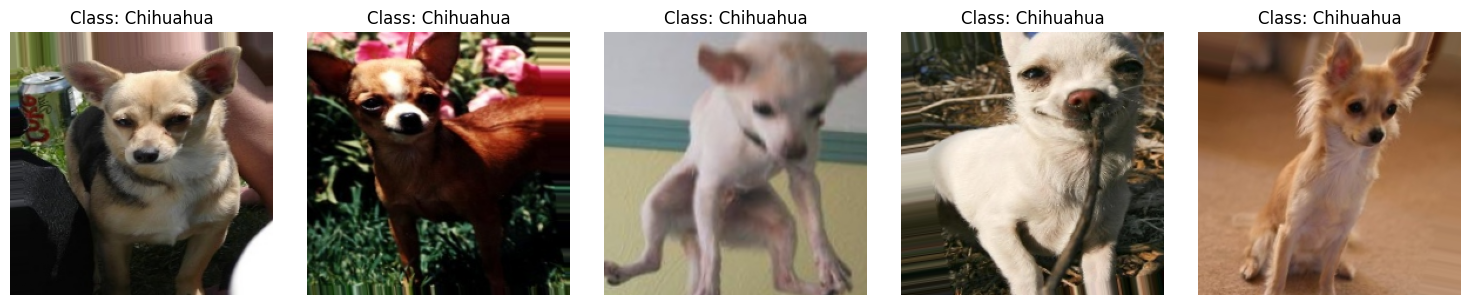


--------------------------------------------------



In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sys
import os

def inspect_hdf5_file(hdf5_path, num_samples_to_display=5):
    if not os.path.exists(hdf5_path):
        print(f"Error: The file '{hdf5_path}' does not exist.")
        return

    with h5py.File(hdf5_path, 'r') as h5f:
        print(f"\nOpened HDF5 file: {hdf5_path}\n")
        
        # List all datasets in the HDF5 file
        datasets = [key for key in h5f.keys() if isinstance(h5f[key], h5py.Dataset)]
        print(f"Datasets found in the file: {datasets}\n")
        
        # Retrieve class_names
        if 'class_names' in h5f:
            class_names = h5f['class_names'][:]
            # Decode bytes to strings if necessary
            class_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in class_names]
            print(f"Class names loaded: {class_names}\n")
        else:
            print("Warning: 'class_names' dataset not found in the HDF5 file.\n")
            class_names = None

        # Check if 'images' and 'labels' datasets exist
        if 'images' in h5f and 'labels' in h5f:
            images = h5f['images']
            labels = h5f['labels']
            
            num_images = images.shape[0]
            num_labels = labels.shape[0]
            image_shape = images.shape[1:] if num_images > 0 else "N/A"
            
            print(f"Number of images: {num_images}")
            print(f"Number of labels: {num_labels}")
            print(f"Image shape: {image_shape}\n")
            
            # Analyze label distribution
            if num_labels > 0 and class_names is not None:
                label_counts = Counter(labels[:])
                print(f"Label distribution:")
                for label, count in label_counts.items():
                    if label < len(class_names):
                        class_name = class_names[label]
                    else:
                        class_name = f"Unknown({label})"
                    print(f"  {class_name}: {count}")
            else:
                print("No labels found or class names unavailable.\n")
            
            # Display sample images
            if num_images > 0 and class_names is not None:
                samples_to_display = min(num_samples_to_display, num_images)
                print(f"\nDisplaying {samples_to_display} sample images:")
                
                plt.figure(figsize=(15, 3))
                for i in range(samples_to_display):
                    img = images[i]
                    label = labels[i]
                    class_name = class_names[label] if label < len(class_names) else f"Unknown({label})"
                    
                    # Ensure image is in [0,1] range and convert to float16
                    img_display = np.clip(img, 0, 1).astype(np.float16)
                    
                    plt.subplot(1, samples_to_display, i + 1)
                    plt.imshow(img_display)
                    plt.title(f"Class: {class_name}")
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            print("\n" + "-"*50 + "\n")
        else:
            print("Error: The HDF5 file does not contain both 'images' and 'labels' datasets.\n")

def main():
    hdf5_path = "dog_dataset_aug_normal.h5"
    num_samples = 5  # Default number of samples to display
    
    inspect_hdf5_file(hdf5_path, num_samples_to_display=num_samples)

if __name__ == "__main__":
    main()


In [ ]:
# Install necessary packages
%pip install h5py scikit-learn tensorflow tqdm

import os
import h5py
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import math

# Define parameters
IMAGE_DIR = r'C:\Users\20200337\Desktop\PROGRAMMATION\02_DOG_RACE_PREDICTION\DATASETS\WEB_DATA\dog_images_1'  # Adjust if necessary
HDF5_FILE = 'THE_best_dataset_and_biggest.h5'
IMAGE_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32  # Adjust as needed
AUGMENTATIONS = {
    'rotation_range': 30,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}
# Additional augmentation parameters
ADDITIONAL_AUGMENT_RATIO = 0.1  # 10% more samples for the largest class

def get_image_paths_and_labels(image_dir):
    image_paths = []
    labels = []
    for race_dir in os.listdir(image_dir):
        race_path = os.path.join(image_dir, race_dir)
        if not os.path.isdir(race_path):
            continue
        for img_file in os.listdir(race_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(race_path, img_file))
                # Remove the prefix (e.g., "n02085620-") from the label
                label = race_dir.split('-', 1)[-1]
                labels.append(label)
    return image_paths, labels

def encode_labels(labels):
    le = LabelEncoder()
    integer_labels = le.fit_transform(labels)
    return integer_labels, le.classes_

def preprocess_image(image_path, target_size):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float16') / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def create_hdf5_dataset(hdf5_file, img_shape, dtype):
    with h5py.File(hdf5_file, 'w') as h5f:
        # Initialize datasets with maxshape=None for unlimited growth
        h5f.create_dataset('images', shape=(0, *img_shape), maxshape=(None, *img_shape), dtype=dtype, chunks=True)
        h5f.create_dataset('labels', shape=(0,), maxshape=(None,), dtype='int')
    print(f"HDF5 file {hdf5_file} created with datasets 'images' and 'labels'.")

def append_to_hdf5(hdf5_file, images, labels):
    with h5py.File(hdf5_file, 'a') as h5f:
        current_size = h5f['images'].shape[0]
        new_size = current_size + images.shape[0]
        
        # Resize datasets to accommodate new data
        h5f['images'].resize((new_size, *h5f['images'].shape[1:]))
        h5f['labels'].resize((new_size,))
        
        # Append data
        h5f['images'][-images.shape[0]:] = images
        h5f['labels'][-images.shape[0]:] = labels

def save_class_names(hdf5_file, class_names):
    with h5py.File(hdf5_file, 'a') as h5f:
        dt = h5py.string_dtype(encoding='utf-8')
        h5f.create_dataset('class_names', data=np.array(class_names, dtype=dt))
    print("Class names saved to HDF5 file.")

def perform_data_augmentation(image_arrays, datagen, augment_count):
    augmented_images = []
    # Calculate the number of batches needed
    batches = math.ceil(augment_count / BATCH_SIZE)
    generator = datagen.flow(image_arrays, batch_size=BATCH_SIZE, shuffle=True)
    for _ in range(batches):
        batch = next(generator)
        augmented_images.extend(batch)
        if len(augmented_images) >= augment_count:
            break
    return np.array(augmented_images[:augment_count])

def main():
    # Step 1: Gather image paths and labels
    print("Gathering image paths and labels...")
    image_paths, labels = get_image_paths_and_labels(IMAGE_DIR)
    print(f"Found {len(image_paths)} images.")

    if len(image_paths) == 0:
        print("No images found. Exiting.")
        return

    # Step 2: Encode labels
    print("Encoding labels...")
    integer_labels, class_names = encode_labels(labels)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")

    # Step 3: Compute class distribution
    print("Computing class distribution...")
    class_counts = {}
    for label in integer_labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    for cls_idx, cls_name in enumerate(class_names):
        print(f"Class '{cls_name}': {class_counts.get(cls_idx,0)} samples")

    # Identify the largest class
    largest_class_idx = max(class_counts, key=class_counts.get)
    largest_class_count = class_counts[largest_class_idx]
    largest_class_name = class_names[largest_class_idx]
    print(f"Largest class is '{largest_class_name}' with {largest_class_count} samples.")

    # Determine target number of samples per class (maximum class size)
    target_count = largest_class_count
    print(f"Target samples per class for balancing: {target_count}")

    # Step 4: Create HDF5 file and datasets
    img_shape = (*IMAGE_SIZE, 3)
    dtype = 'float16'
    create_hdf5_dataset(HDF5_FILE, img_shape, dtype)

    # Step 5: Initialize ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(**AUGMENTATIONS)

    # Step 6: Process and save original images
    print("Processing and saving original images...")
    for cls_idx, cls_name in enumerate(class_names):
        cls_indices = [i for i, label in enumerate(integer_labels) if label == cls_idx]
        cls_image_paths = [image_paths[i] for i in cls_indices]
        cls_labels = [cls_idx] * len(cls_image_paths)
        
        images = []
        labels_batch = []
        for img_path in tqdm(cls_image_paths, desc=f"Class '{cls_name}' original"):
            img = preprocess_image(img_path, IMAGE_SIZE)
            if img is not None:
                images.append(img)
                labels_batch.append(cls_idx)
        
        if images:
            images_np = np.array(images, dtype=dtype)
            labels_np = np.array(labels_batch, dtype='int')
            append_to_hdf5(HDF5_FILE, images_np, labels_np)
        
        current_count = class_counts.get(cls_idx, 0)
        augment_needed = target_count - current_count
        if augment_needed > 0:
            print(f"Augmenting {augment_needed} samples for class '{cls_name}'...")
            # Load images again for augmentation
            images_for_augmentation = []
            for img_path in cls_image_paths:
                img = preprocess_image(img_path, IMAGE_SIZE)
                if img is not None:
                    images_for_augmentation.append(img)
            if not images_for_augmentation:
                print(f"No images available for augmentation in class '{cls_name}'. Skipping.")
                continue
            images_array = np.array(images_for_augmentation, dtype=dtype)
            augmented_images = perform_data_augmentation(images_array, datagen, augment_needed)
            # Normalize augmented images
            augmented_images = augmented_images.astype('float16') / 255.0
            augmented_labels = np.array([cls_idx] * augmented_images.shape[0], dtype='int')
            append_to_hdf5(HDF5_FILE, augmented_images, augmented_labels)
            print(f"Added {augmented_images.shape[0]} augmented samples for class '{cls_name}'.")

    # Step 7: Additional augmentation for the largest class
    print(f"Performing additional augmentation for the largest class '{largest_class_name}' to enhance generalization...")
    additional_augment_count = math.ceil(class_counts[largest_class_idx] * ADDITIONAL_AUGMENT_RATIO)
    print(f"Adding {additional_augment_count} additional augmented samples for class '{largest_class_name}'.")

    # Load original images of the largest class
    largest_cls_indices = [i for i, label in enumerate(integer_labels) if label == largest_class_idx]
    largest_cls_image_paths = [image_paths[i] for i in largest_cls_indices]
    largest_cls_labels = [largest_class_idx] * len(largest_cls_image_paths)
    
    images_for_additional_augmentation = []
    for img_path in largest_cls_image_paths:
        img = preprocess_image(img_path, IMAGE_SIZE)
        if img is not None:
            images_for_additional_augmentation.append(img)
    if images_for_additional_augmentation:
        images_array = np.array(images_for_additional_augmentation, dtype=dtype)
        augmented_images = perform_data_augmentation(images_array, datagen, additional_augment_count)
        # Normalize augmented images
        augmented_images = augmented_images.astype('float16') / 255.0
        augmented_labels = np.array([largest_class_idx] * augmented_images.shape[0], dtype='int')
        append_to_hdf5(HDF5_FILE, augmented_images, augmented_labels)
        print(f"Added {augmented_images.shape[0]} additional augmented samples for class '{largest_class_name}'.")
    else:
        print(f"No images available for additional augmentation in class '{largest_class_name}'.")

    # Step 8: Save class names
    save_class_names(HDF5_FILE, class_names)

    print("HDF5 dataset creation with balanced and enhanced augmentation complete.")

if __name__ == "__main__":
    main()


Note: you may need to restart the kernel to use updated packages.
Gathering image paths and labels...
Found 195405 images.
Encoding labels...
Number of classes: 120
Classes: ['Tzu' 'affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'and-tan_coonhound' 'appenzeller'
 'australian_terrier' 'basenji' 'basset' 'beagle' 'bedlington_terrier'
 'bernese_mountain_dog' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber'
 'coated_retriever' 'coated_wheaten_terrier' 'cocker_spaniel' 'collie'
 'dandie_dinmont' 'dhole' 'dingo' 'doberman' 'english_foxhound'
 'english_setter' 'english_springer' 'entlebucher' 'eskimo_dog'
 'flat_coated_retriever' 'french_bulldog' 'german_shepherd'
 'giant_schnauzer' 'golden_retriever' 'gordon_setter' 'great_

Class 'Tzu' original: 100%|██████████| 3416/3416 [00:02<00:00, 1352.58it/s]


Augmenting 2513 samples for class 'Tzu'...
Added 2513 augmented samples for class 'Tzu'.


Class 'affenpinscher' original: 100%|██████████| 539/539 [00:00<00:00, 1571.25it/s]


Augmenting 5390 samples for class 'affenpinscher'...
Added 5363 augmented samples for class 'affenpinscher'.


Class 'afghan_hound' original: 100%|██████████| 2269/2269 [00:04<00:00, 546.95it/s]


Augmenting 3660 samples for class 'afghan_hound'...
Added 3660 augmented samples for class 'afghan_hound'.


Class 'african_hunting_dog' original: 100%|██████████| 1390/1390 [00:01<00:00, 1267.26it/s]


Augmenting 4539 samples for class 'african_hunting_dog'...
Added 4490 augmented samples for class 'african_hunting_dog'.


Class 'airedale' original: 100%|██████████| 1883/1883 [00:01<00:00, 1224.02it/s]


Augmenting 4046 samples for class 'airedale'...
Added 4046 augmented samples for class 'airedale'.


Class 'american_staffordshire_terrier' original: 100%|██████████| 1300/1300 [00:01<00:00, 1200.06it/s]


Augmenting 4629 samples for class 'american_staffordshire_terrier'...
Added 4604 augmented samples for class 'american_staffordshire_terrier'.


Class 'and-tan_coonhound' original: 100%|██████████| 868/868 [00:00<00:00, 1077.42it/s]


Augmenting 5061 samples for class 'and-tan_coonhound'...
Added 4948 augmented samples for class 'and-tan_coonhound'.


Class 'appenzeller' original: 100%|██████████| 251/251 [00:02<00:00, 122.14it/s]


Augmenting 5678 samples for class 'appenzeller'...
Added 5586 augmented samples for class 'appenzeller'.


Class 'australian_terrier' original: 100%|██████████| 605/605 [00:03<00:00, 161.83it/s]


Augmenting 5324 samples for class 'australian_terrier'...
Added 5320 augmented samples for class 'australian_terrier'.


Class 'basenji' original: 100%|██████████| 1832/1832 [00:10<00:00, 182.31it/s]


Augmenting 4097 samples for class 'basenji'...
Added 4080 augmented samples for class 'basenji'.


Class 'basset' original: 100%|██████████| 3128/3128 [00:08<00:00, 389.01it/s]


Augmenting 2801 samples for class 'basset'...
Added 2801 augmented samples for class 'basset'.


Class 'beagle' original: 100%|██████████| 3481/3481 [00:04<00:00, 770.52it/s]


Augmenting 2448 samples for class 'beagle'...
Added 2448 augmented samples for class 'beagle'.


Class 'bedlington_terrier' original: 100%|██████████| 728/728 [00:04<00:00, 170.51it/s]


Augmenting 5201 samples for class 'bedlington_terrier'...
Added 5160 augmented samples for class 'bedlington_terrier'.


Class 'bernese_mountain_dog' original: 100%|██████████| 4283/4283 [00:19<00:00, 216.42it/s]


Augmenting 1646 samples for class 'bernese_mountain_dog'...
Added 1646 augmented samples for class 'bernese_mountain_dog'.


Class 'blenheim_spaniel' original: 100%|██████████| 3517/3517 [00:07<00:00, 469.01it/s]


Augmenting 2412 samples for class 'blenheim_spaniel'...
Added 2412 augmented samples for class 'blenheim_spaniel'.


Class 'bloodhound' original: 100%|██████████| 1672/1672 [00:02<00:00, 706.31it/s]


Augmenting 4257 samples for class 'bloodhound'...
Added 4240 augmented samples for class 'bloodhound'.


Class 'bluetick' original: 100%|██████████| 763/763 [00:06<00:00, 116.23it/s]


Augmenting 5166 samples for class 'bluetick'...
Added 5154 augmented samples for class 'bluetick'.


Class 'border_collie' original: 100%|██████████| 1543/1543 [00:11<00:00, 130.86it/s]


Augmenting 4386 samples for class 'border_collie'...
Added 4366 augmented samples for class 'border_collie'.


Class 'border_terrier' original: 100%|██████████| 1469/1469 [00:02<00:00, 698.31it/s]


Augmenting 4460 samples for class 'border_terrier'...
Added 4460 augmented samples for class 'border_terrier'.


Class 'borzoi' original: 100%|██████████| 2439/2439 [00:15<00:00, 157.52it/s]


Augmenting 3490 samples for class 'borzoi'...
Added 3490 augmented samples for class 'borzoi'.


Class 'boston_bull' original: 100%|██████████| 2558/2558 [00:12<00:00, 209.67it/s]


Augmenting 3371 samples for class 'boston_bull'...
Added 3371 augmented samples for class 'boston_bull'.


Class 'bouvier_des_flandres' original: 100%|██████████| 683/683 [00:07<00:00, 94.76it/s] 


Augmenting 5246 samples for class 'bouvier_des_flandres'...
Added 5101 augmented samples for class 'bouvier_des_flandres'.


Class 'boxer' original: 100%|██████████| 1301/1301 [00:11<00:00, 115.94it/s]


Augmenting 4628 samples for class 'boxer'...
Added 4607 augmented samples for class 'boxer'.


Class 'brabancon_griffon' original: 100%|██████████| 1360/1360 [00:02<00:00, 479.58it/s]


Augmenting 4569 samples for class 'brabancon_griffon'...
Added 4528 augmented samples for class 'brabancon_griffon'.


Class 'briard' original: 100%|██████████| 800/800 [00:12<00:00, 63.36it/s] 


Augmenting 5129 samples for class 'briard'...
Added 5129 augmented samples for class 'briard'.


Class 'brittany_spaniel' original: 100%|██████████| 1276/1276 [00:15<00:00, 82.94it/s] 


Augmenting 4653 samples for class 'brittany_spaniel'...
Added 4653 augmented samples for class 'brittany_spaniel'.


Class 'bull_mastiff' original: 100%|██████████| 1466/1466 [00:14<00:00, 99.00it/s] 


Augmenting 4463 samples for class 'bull_mastiff'...
Added 4462 augmented samples for class 'bull_mastiff'.


Class 'cairn' original: 100%|██████████| 773/773 [00:11<00:00, 67.43it/s] 


Augmenting 5156 samples for class 'cairn'...
Added 5022 augmented samples for class 'cairn'.


Class 'cardigan' original: 100%|██████████| 599/599 [00:06<00:00, 98.76it/s] 


Augmenting 5330 samples for class 'cardigan'...
Added 5272 augmented samples for class 'cardigan'.


Class 'chesapeake_bay_retriever' original: 100%|██████████| 1411/1411 [00:13<00:00, 101.08it/s]


Augmenting 4518 samples for class 'chesapeake_bay_retriever'...
Added 4457 augmented samples for class 'chesapeake_bay_retriever'.


Class 'chihuahua' original: 100%|██████████| 3496/3496 [00:12<00:00, 288.03it/s]


Augmenting 2433 samples for class 'chihuahua'...
Added 2433 augmented samples for class 'chihuahua'.


Class 'chow' original: 100%|██████████| 1014/1014 [00:15<00:00, 64.19it/s]


Augmenting 4915 samples for class 'chow'...
Added 4888 augmented samples for class 'chow'.


Class 'clumber' original: 100%|██████████| 708/708 [00:07<00:00, 88.82it/s] 


Augmenting 5221 samples for class 'clumber'...
Added 5052 augmented samples for class 'clumber'.


Class 'coated_retriever' original: 100%|██████████| 1369/1369 [00:13<00:00, 99.33it/s] 


Augmenting 4560 samples for class 'coated_retriever'...
Added 4555 augmented samples for class 'coated_retriever'.


Class 'coated_wheaten_terrier' original: 100%|██████████| 1124/1124 [00:08<00:00, 136.13it/s]


Augmenting 4805 samples for class 'coated_wheaten_terrier'...
Added 4720 augmented samples for class 'coated_wheaten_terrier'.


Class 'cocker_spaniel' original: 100%|██████████| 1215/1215 [00:08<00:00, 137.86it/s]


Augmenting 4714 samples for class 'cocker_spaniel'...
Added 4714 augmented samples for class 'cocker_spaniel'.


Class 'collie' original: 100%|██████████| 463/463 [00:05<00:00, 90.44it/s] 


Augmenting 5466 samples for class 'collie'...
Added 5285 augmented samples for class 'collie'.


Class 'dandie_dinmont' original: 100%|██████████| 667/667 [00:08<00:00, 80.89it/s] 


Augmenting 5262 samples for class 'dandie_dinmont'...
Added 5245 augmented samples for class 'dandie_dinmont'.


Class 'dhole' original: 100%|██████████| 804/804 [00:09<00:00, 88.64it/s] 


Augmenting 5125 samples for class 'dhole'...
Added 4984 augmented samples for class 'dhole'.


Class 'dingo' original: 100%|██████████| 1264/1264 [00:14<00:00, 87.56it/s] 


Augmenting 4665 samples for class 'dingo'...
Added 4624 augmented samples for class 'dingo'.


Class 'doberman' original: 100%|██████████| 2183/2183 [00:03<00:00, 678.82it/s]


Augmenting 3746 samples for class 'doberman'...
Added 3746 augmented samples for class 'doberman'.


Class 'english_foxhound' original: 100%|██████████| 850/850 [00:14<00:00, 57.97it/s] 


Augmenting 5079 samples for class 'english_foxhound'...
Added 5018 augmented samples for class 'english_foxhound'.


Class 'english_setter' original: 100%|██████████| 1166/1166 [00:10<00:00, 108.97it/s]


Augmenting 4763 samples for class 'english_setter'...
Added 4696 augmented samples for class 'english_setter'.


Class 'english_springer' original: 100%|██████████| 1375/1375 [00:02<00:00, 685.20it/s]


Augmenting 4554 samples for class 'english_springer'...
Added 4554 augmented samples for class 'english_springer'.


Class 'entlebucher' original: 100%|██████████| 980/980 [00:13<00:00, 71.67it/s] 


Augmenting 4949 samples for class 'entlebucher'...
Added 4900 augmented samples for class 'entlebucher'.


Class 'eskimo_dog' original: 100%|██████████| 55/55 [00:00<00:00, 68.32it/s]


Augmenting 5874 samples for class 'eskimo_dog'...
Added 5060 augmented samples for class 'eskimo_dog'.


Class 'flat_coated_retriever' original: 100%|██████████| 4237/4237 [00:28<00:00, 146.22it/s]


Augmenting 1692 samples for class 'flat_coated_retriever'...
Added 1692 augmented samples for class 'flat_coated_retriever'.


Class 'french_bulldog' original: 100%|██████████| 1831/1831 [00:02<00:00, 694.18it/s]


Augmenting 4098 samples for class 'french_bulldog'...
Added 4078 augmented samples for class 'french_bulldog'.


Class 'german_shepherd' original: 100%|██████████| 5544/5544 [00:30<00:00, 184.21it/s]


Augmenting 385 samples for class 'german_shepherd'...
Added 385 augmented samples for class 'german_shepherd'.


Class 'giant_schnauzer' original: 100%|██████████| 693/693 [00:05<00:00, 131.65it/s]


Augmenting 5236 samples for class 'giant_schnauzer'...
Added 5171 augmented samples for class 'giant_schnauzer'.


Class 'golden_retriever' original: 100%|██████████| 4580/4580 [00:19<00:00, 230.82it/s]


Augmenting 1349 samples for class 'golden_retriever'...
Added 1349 augmented samples for class 'golden_retriever'.


Class 'gordon_setter' original: 100%|██████████| 1072/1072 [00:01<00:00, 654.31it/s]


Augmenting 4857 samples for class 'gordon_setter'...
Added 4800 augmented samples for class 'gordon_setter'.


Class 'great_dane' original: 100%|██████████| 1400/1400 [00:16<00:00, 82.79it/s] 


Augmenting 4529 samples for class 'great_dane'...
Added 4520 augmented samples for class 'great_dane'.


Class 'great_pyrenees' original: 100%|██████████| 1221/1221 [00:07<00:00, 162.75it/s]


Augmenting 4708 samples for class 'great_pyrenees'...
Added 4655 augmented samples for class 'great_pyrenees'.


Class 'greater_swiss_mountain_dog' original: 100%|██████████| 426/426 [00:05<00:00, 73.42it/s] 


Augmenting 5503 samples for class 'greater_swiss_mountain_dog'...
Added 5240 augmented samples for class 'greater_swiss_mountain_dog'.


Class 'groenendael' original: 100%|██████████| 1055/1055 [00:07<00:00, 136.17it/s]


Augmenting 4874 samples for class 'groenendael'...
Added 4874 augmented samples for class 'groenendael'.


Class 'haired_fox_terrier' original: 100%|██████████| 1140/1140 [00:09<00:00, 120.80it/s]


Augmenting 4789 samples for class 'haired_fox_terrier'...
Added 4752 augmented samples for class 'haired_fox_terrier'.


Class 'haired_pointer' original: 100%|██████████| 1763/1763 [00:12<00:00, 145.84it/s]


Augmenting 4166 samples for class 'haired_pointer'...
Added 4134 augmented samples for class 'haired_pointer'.


Class 'ibizan_hound' original: 100%|██████████| 1397/1397 [00:11<00:00, 119.30it/s]


Augmenting 4532 samples for class 'ibizan_hound'...
Added 4511 augmented samples for class 'ibizan_hound'.


Class 'irish_setter' original: 100%|██████████| 2932/2932 [00:12<00:00, 229.13it/s]


Augmenting 2997 samples for class 'irish_setter'...
Added 2996 augmented samples for class 'irish_setter'.


Class 'irish_terrier' original: 100%|██████████| 1065/1065 [00:07<00:00, 142.79it/s]


Augmenting 4864 samples for class 'irish_terrier'...
Added 4772 augmented samples for class 'irish_terrier'.


Class 'irish_water_spaniel' original: 100%|██████████| 271/271 [00:02<00:00, 102.28it/s]


Augmenting 5658 samples for class 'irish_water_spaniel'...
Added 5341 augmented samples for class 'irish_water_spaniel'.


Class 'irish_wolfhound' original: 100%|██████████| 1383/1383 [00:08<00:00, 170.78it/s]


Augmenting 4546 samples for class 'irish_wolfhound'...
Added 4501 augmented samples for class 'irish_wolfhound'.


Class 'italian_greyhound' original: 100%|██████████| 1674/1674 [00:23<00:00, 71.41it/s] 


Augmenting 4255 samples for class 'italian_greyhound'...
Added 4212 augmented samples for class 'italian_greyhound'.


Class 'japanese_spaniel' original: 100%|██████████| 1655/1655 [00:16<00:00, 103.30it/s]


Augmenting 4274 samples for class 'japanese_spaniel'...
Added 4270 augmented samples for class 'japanese_spaniel'.


Class 'keeshond' original: 100%|██████████| 1513/1513 [00:29<00:00, 52.15it/s] 


Augmenting 4416 samples for class 'keeshond'...
Added 4370 augmented samples for class 'keeshond'.


Class 'kelpie' original: 100%|██████████| 1517/1517 [00:17<00:00, 87.11it/s] 


Augmenting 4412 samples for class 'kelpie'...
Added 4378 augmented samples for class 'kelpie'.


Class 'kerry_blue_terrier' original: 100%|██████████| 590/590 [00:05<00:00, 116.01it/s]


Augmenting 5339 samples for class 'kerry_blue_terrier'...
Added 5200 augmented samples for class 'kerry_blue_terrier'.


Class 'komondor' original: 100%|██████████| 363/363 [00:05<00:00, 69.98it/s] 


Augmenting 5566 samples for class 'komondor'...
Added 5274 augmented samples for class 'komondor'.


Class 'kuvasz' original: 100%|██████████| 673/673 [00:01<00:00, 531.90it/s]


Augmenting 5256 samples for class 'kuvasz'...
Added 5063 augmented samples for class 'kuvasz'.


Class 'labrador_retriever' original: 100%|██████████| 3926/3926 [00:30<00:00, 128.61it/s]


Augmenting 2003 samples for class 'labrador_retriever'...
Added 2003 augmented samples for class 'labrador_retriever'.


Class 'lakeland_terrier' original: 100%|██████████| 550/550 [00:06<00:00, 83.16it/s] 


Augmenting 5379 samples for class 'lakeland_terrier'...
Added 5174 augmented samples for class 'lakeland_terrier'.


Class 'leonberg' original: 100%|██████████| 1419/1419 [00:08<00:00, 171.39it/s]


Augmenting 4510 samples for class 'leonberg'...
Added 4449 augmented samples for class 'leonberg'.


Class 'lhasa' original: 100%|██████████| 522/522 [00:04<00:00, 114.44it/s]


Augmenting 5407 samples for class 'lhasa'...
Added 5210 augmented samples for class 'lhasa'.


Class 'malamute' original: 100%|██████████| 1193/1193 [00:12<00:00, 98.40it/s] 


Augmenting 4736 samples for class 'malamute'...
Added 4667 augmented samples for class 'malamute'.


Class 'malinois' original: 100%|██████████| 2171/2171 [00:17<00:00, 122.18it/s]


Augmenting 3758 samples for class 'malinois'...
Added 3758 augmented samples for class 'malinois'.


Class 'maltese_dog' original: 100%|██████████| 4167/4167 [00:10<00:00, 415.41it/s]


Augmenting 1762 samples for class 'maltese_dog'...
Added 1762 augmented samples for class 'maltese_dog'.


Class 'mexican_hairless' original: 100%|██████████| 986/986 [00:14<00:00, 66.04it/s] 


Augmenting 4943 samples for class 'mexican_hairless'...
Added 4930 augmented samples for class 'mexican_hairless'.


Class 'miniature_pinscher' original: 100%|██████████| 1557/1557 [00:07<00:00, 218.07it/s]


Augmenting 4372 samples for class 'miniature_pinscher'...
Added 4362 augmented samples for class 'miniature_pinscher'.


Class 'miniature_poodle' original: 100%|██████████| 434/434 [00:03<00:00, 144.10it/s]


Augmenting 5495 samples for class 'miniature_poodle'...
Added 5336 augmented samples for class 'miniature_poodle'.


Class 'miniature_schnauzer' original: 100%|██████████| 1434/1434 [00:16<00:00, 86.42it/s] 


Augmenting 4495 samples for class 'miniature_schnauzer'...
Added 4494 augmented samples for class 'miniature_schnauzer'.


Class 'newfoundland' original: 100%|██████████| 1070/1070 [00:01<00:00, 686.91it/s]


Augmenting 4859 samples for class 'newfoundland'...
Added 4792 augmented samples for class 'newfoundland'.


Class 'norfolk_terrier' original: 100%|██████████| 654/654 [00:08<00:00, 78.11it/s] 


Augmenting 5275 samples for class 'norfolk_terrier'...
Added 5154 augmented samples for class 'norfolk_terrier'.


Class 'norwegian_elkhound' original: 100%|██████████| 1532/1532 [00:10<00:00, 145.01it/s]


Augmenting 4397 samples for class 'norwegian_elkhound'...
Added 4397 augmented samples for class 'norwegian_elkhound'.


Class 'norwich_terrier' original: 100%|██████████| 973/973 [00:11<00:00, 84.16it/s] 


Augmenting 4956 samples for class 'norwich_terrier'...
Added 4865 augmented samples for class 'norwich_terrier'.


Class 'old_english_sheepdog' original: 100%|██████████| 1484/1484 [00:12<00:00, 116.58it/s]


Augmenting 4445 samples for class 'old_english_sheepdog'...
Added 4408 augmented samples for class 'old_english_sheepdog'.


Class 'otterhound' original: 100%|██████████| 741/741 [00:09<00:00, 78.47it/s] 


Augmenting 5188 samples for class 'otterhound'...
Added 5054 augmented samples for class 'otterhound'.


Class 'papillon' original: 100%|██████████| 3895/3895 [00:18<00:00, 205.17it/s]


Augmenting 2034 samples for class 'papillon'...
Added 2034 augmented samples for class 'papillon'.


Class 'pekinese' original: 100%|██████████| 3320/3320 [00:21<00:00, 157.00it/s]


Augmenting 2609 samples for class 'pekinese'...
Added 2609 augmented samples for class 'pekinese'.


Class 'pembroke' original: 100%|██████████| 1454/1454 [00:09<00:00, 160.10it/s]


Augmenting 4475 samples for class 'pembroke'...
Added 4426 augmented samples for class 'pembroke'.


Class 'pomeranian' original: 100%|██████████| 1169/1169 [00:03<00:00, 365.77it/s]


Augmenting 4760 samples for class 'pomeranian'...
Added 4708 augmented samples for class 'pomeranian'.


Class 'pug' original: 100%|██████████| 2188/2188 [00:17<00:00, 128.64it/s]


Augmenting 3741 samples for class 'pug'...
Added 3724 augmented samples for class 'pug'.


Class 'redbone' original: 100%|██████████| 560/560 [00:04<00:00, 135.76it/s]


Augmenting 5369 samples for class 'redbone'...
Added 5232 augmented samples for class 'redbone'.


Class 'rhodesian_ridgeback' original: 100%|██████████| 4115/4115 [00:30<00:00, 136.66it/s]


Augmenting 1814 samples for class 'rhodesian_ridgeback'...
Added 1814 augmented samples for class 'rhodesian_ridgeback'.


Class 'rottweiler' original: 100%|██████████| 3825/3825 [00:11<00:00, 343.92it/s]


Augmenting 2104 samples for class 'rottweiler'...
Added 2104 augmented samples for class 'rottweiler'.


Class 'saint_bernard' original: 100%|██████████| 2178/2178 [00:14<00:00, 153.84it/s]


Augmenting 3751 samples for class 'saint_bernard'...
Added 3746 augmented samples for class 'saint_bernard'.


Class 'saluki' original: 100%|██████████| 1914/1914 [00:08<00:00, 225.28it/s]


Augmenting 4015 samples for class 'saluki'...
Added 4015 augmented samples for class 'saluki'.


Class 'samoyed' original: 100%|██████████| 2683/2683 [00:09<00:00, 277.99it/s]


Augmenting 3246 samples for class 'samoyed'...
Added 3246 augmented samples for class 'samoyed'.


Class 'schipperke' original: 100%|██████████| 1595/1595 [00:10<00:00, 154.61it/s]


Augmenting 4334 samples for class 'schipperke'...
Added 4334 augmented samples for class 'schipperke'.


Class 'scotch_terrier' original: 100%|██████████| 969/969 [00:06<00:00, 151.76it/s]


Augmenting 4960 samples for class 'scotch_terrier'...
Added 4845 augmented samples for class 'scotch_terrier'.


Class 'scottish_deerhound' original: 100%|██████████| 1352/1352 [00:08<00:00, 150.24it/s]


Augmenting 4577 samples for class 'scottish_deerhound'...
Added 4536 augmented samples for class 'scottish_deerhound'.


Class 'sealyham_terrier' original: 100%|██████████| 855/855 [00:07<00:00, 117.39it/s]


Augmenting 5074 samples for class 'sealyham_terrier'...
Added 5043 augmented samples for class 'sealyham_terrier'.


Class 'shetland_sheepdog' original: 100%|██████████| 1546/1546 [00:16<00:00, 92.72it/s] 


Augmenting 4383 samples for class 'shetland_sheepdog'...
Added 4340 augmented samples for class 'shetland_sheepdog'.


Class 'siberian_husky' original: 100%|██████████| 2435/2435 [00:12<00:00, 197.34it/s]


Augmenting 3494 samples for class 'siberian_husky'...
Added 3491 augmented samples for class 'siberian_husky'.


Class 'silky_terrier' original: 100%|██████████| 282/282 [00:07<00:00, 37.80it/s]


Augmenting 5647 samples for class 'silky_terrier'...
Added 5550 augmented samples for class 'silky_terrier'.


Class 'staffordshire_bullterrier' original: 100%|██████████| 1035/1035 [00:12<00:00, 80.63it/s]


Augmenting 4894 samples for class 'staffordshire_bullterrier'...
Added 4812 augmented samples for class 'staffordshire_bullterrier'.


Class 'standard_poodle' original: 100%|██████████| 908/908 [00:06<00:00, 147.04it/s]


Augmenting 5021 samples for class 'standard_poodle'...
Added 4924 augmented samples for class 'standard_poodle'.


Class 'standard_schnauzer' original: 100%|██████████| 730/730 [00:09<00:00, 74.61it/s] 


Augmenting 5199 samples for class 'standard_schnauzer'...
Added 5174 augmented samples for class 'standard_schnauzer'.


Class 'sussex_spaniel' original: 100%|██████████| 803/803 [00:04<00:00, 184.80it/s]


Augmenting 5126 samples for class 'sussex_spaniel'...
Added 4978 augmented samples for class 'sussex_spaniel'.


Class 'tibetan_mastiff' original: 100%|██████████| 1073/1073 [00:07<00:00, 151.02it/s]


Augmenting 4856 samples for class 'tibetan_mastiff'...
Added 4804 augmented samples for class 'tibetan_mastiff'.


Class 'tibetan_terrier' original: 100%|██████████| 1429/1429 [00:09<00:00, 152.96it/s]


Augmenting 4500 samples for class 'tibetan_terrier'...
Added 4479 augmented samples for class 'tibetan_terrier'.


Class 'toy_poodle' original: 100%|██████████| 541/541 [00:02<00:00, 266.42it/s]


Augmenting 5388 samples for class 'toy_poodle'...
Added 5381 augmented samples for class 'toy_poodle'.


Class 'toy_terrier' original: 100%|██████████| 640/640 [00:07<00:00, 81.71it/s] 


Augmenting 5289 samples for class 'toy_terrier'...
Added 5289 augmented samples for class 'toy_terrier'.


Class 'walker_hound' original: 100%|██████████| 405/405 [00:07<00:00, 53.38it/s] 


Augmenting 5524 samples for class 'walker_hound'...
Added 5393 augmented samples for class 'walker_hound'.


Class 'weimaraner' original: 100%|██████████| 3726/3726 [00:27<00:00, 136.54it/s]


Augmenting 2203 samples for class 'weimaraner'...
Added 2203 augmented samples for class 'weimaraner'.


Class 'welsh_springer_spaniel' original: 100%|██████████| 903/903 [00:13<00:00, 67.54it/s] 


Augmenting 5026 samples for class 'welsh_springer_spaniel'...
Added 4931 augmented samples for class 'welsh_springer_spaniel'.


Class 'west_highland_white_terrier' original: 100%|██████████| 3233/3233 [00:29<00:00, 111.41it/s]


Augmenting 2696 samples for class 'west_highland_white_terrier'...
Added 2696 augmented samples for class 'west_highland_white_terrier'.


Class 'whippet' original: 100%|██████████| 2314/2314 [00:09<00:00, 252.84it/s]


Augmenting 3615 samples for class 'whippet'...
Added 3594 augmented samples for class 'whippet'.


Class 'yorkshire_terrier' original: 100%|██████████| 2257/2257 [00:27<00:00, 81.49it/s] 


Augmenting 3672 samples for class 'yorkshire_terrier'...
Added 3665 augmented samples for class 'yorkshire_terrier'.
Performing additional augmentation for the largest class 'vizsla' to enhance generalization...
Adding 593 additional augmented samples for class 'vizsla'.
Added 593 additional augmented samples for class 'vizsla'.
Class names saved to HDF5 file.
HDF5 dataset creation with balanced and enhanced augmentation complete.


In [ ]:
# Install necessary packages
%pip install h5py scikit-learn tensorflow tqdm

import os
import h5py
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import math
import random

# Define parameters
IMAGE_DIR = r'C:\Users\20200337\Desktop\PROGRAMMATION\02_DOG_RACE_PREDICTION\DATASETS\WEB_DATA\dog_images_1'  # Adjust if necessary
HDF5_FILE = '1000_images_web_dataset.h5'
IMAGE_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32  # Adjust as needed
TARGET_COUNT_PER_CLASS = 1000  # Desired number of images per class

AUGMENTATIONS = {
    'rotation_range': 30,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

def get_image_paths_and_labels(image_dir):
    """
    Gathers image file paths and their corresponding labels from the directory structure.
    
    Args:
        image_dir (str): Path to the main image directory.
        
    Returns:
        tuple: (list of image paths, list of labels)
    """
    image_paths = []
    labels = []
    for race_dir in os.listdir(image_dir):
        race_path = os.path.join(image_dir, race_dir)
        if not os.path.isdir(race_path):
            continue
        for img_file in os.listdir(race_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(race_path, img_file))
                # Extract label by removing any prefix (e.g., "n02085620-") from the directory name
                label = race_dir.split('-', 1)[-1]
                labels.append(label)
    return image_paths, labels

def encode_labels(labels):
    """
    Encodes string labels into integer labels.
    
    Args:
        labels (list): List of string labels.
        
    Returns:
        tuple: (numpy array of integer labels, list of class names)
    """
    le = LabelEncoder()
    integer_labels = le.fit_transform(labels)
    return integer_labels, le.classes_

def preprocess_image(image_path, target_size):
    """
    Loads and preprocesses an image.
    
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size.
        
    Returns:
        numpy array or None: Preprocessed image array or None if an error occurs.
    """
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.astype('float16') / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def create_hdf5_dataset(hdf5_file, img_shape, dtype):
    """
    Creates an HDF5 file with datasets for images and labels.
    
    Args:
        hdf5_file (str): Path to the HDF5 file.
        img_shape (tuple): Shape of each image.
        dtype (str): Data type for the images.
    """
    with h5py.File(hdf5_file, 'w') as h5f:
        # Initialize datasets with maxshape=None for unlimited growth
        h5f.create_dataset('images', shape=(0, *img_shape), maxshape=(None, *img_shape), dtype=dtype, chunks=True)
        h5f.create_dataset('labels', shape=(0,), maxshape=(None,), dtype='int')
    print(f"HDF5 file '{hdf5_file}' created with datasets 'images' and 'labels'.")

def append_to_hdf5(hdf5_file, images, labels):
    """
    Appends images and labels to the HDF5 datasets.
    
    Args:
        hdf5_file (str): Path to the HDF5 file.
        images (numpy array): Array of images to append.
        labels (numpy array): Array of labels to append.
    """
    with h5py.File(hdf5_file, 'a') as h5f:
        current_size = h5f['images'].shape[0]
        new_size = current_size + images.shape[0]
        
        # Resize datasets to accommodate new data
        h5f['images'].resize((new_size, *h5f['images'].shape[1:]))
        h5f['labels'].resize((new_size,))
        
        # Append data
        h5f['images'][-images.shape[0]:] = images
        h5f['labels'][-images.shape[0]:] = labels

def save_class_names(hdf5_file, class_names):
    """
    Saves the class names to the HDF5 file.
    
    Args:
        hdf5_file (str): Path to the HDF5 file.
        class_names (list): List of class names.
    """
    with h5py.File(hdf5_file, 'a') as h5f:
        dt = h5py.string_dtype(encoding='utf-8')
        h5f.create_dataset('class_names', data=np.array(class_names, dtype=dt))
    print("Class names saved to HDF5 file.")

def perform_data_augmentation(image_arrays, datagen, augment_count):
    """
    Performs data augmentation to generate augmented images.
    
    Args:
        image_arrays (numpy array): Array of original images.
        datagen (ImageDataGenerator): Keras ImageDataGenerator instance.
        augment_count (int): Number of augmented images to generate.
        
    Returns:
        numpy array: Array of augmented images.
    """
    augmented_images = []
    # Calculate the number of batches needed
    batches = math.ceil(augment_count / BATCH_SIZE)
    generator = datagen.flow(image_arrays, batch_size=BATCH_SIZE, shuffle=True)
    for _ in range(batches):
        batch = next(generator)
        augmented_images.extend(batch)
        if len(augmented_images) >= augment_count:
            break
    return np.array(augmented_images[:augment_count])

def main():
    """
    Main function to create a balanced HDF5 dataset with a fixed number of images per class.
    """
    # Step 1: Gather image paths and labels
    print("Gathering image paths and labels...")
    image_paths, labels = get_image_paths_and_labels(IMAGE_DIR)
    print(f"Found {len(image_paths)} images across {len(set(labels))} classes.")
    
    if len(image_paths) == 0:
        print("No images found. Exiting.")
        return
    
    # Step 2: Encode labels
    print("Encoding labels...")
    integer_labels, class_names = encode_labels(labels)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")
    
    # Step 3: Compute class distribution
    print("Computing class distribution...")
    class_counts = {}
    for label in integer_labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    for cls_idx, cls_name in enumerate(class_names):
        print(f"Class '{cls_name}': {class_counts.get(cls_idx,0)} samples")
    
    # Step 4: Set target count per class
    target_count = TARGET_COUNT_PER_CLASS
    print(f"Target samples per class: {target_count}")
    
    # Step 5: Create HDF5 file and datasets
    img_shape = (*IMAGE_SIZE, 3)
    dtype = 'float16'
    create_hdf5_dataset(HDF5_FILE, img_shape, dtype)
    
    # Step 6: Initialize ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(**AUGMENTATIONS)
    
    # Step 7: Process and save images per class
    print("Processing and saving images per class...")
    for cls_idx, cls_name in enumerate(class_names):
        cls_indices = [i for i, label in enumerate(integer_labels) if label == cls_idx]
        cls_image_paths = [image_paths[i] for i in cls_indices]
        cls_labels = [cls_idx] * len(cls_image_paths)
        
        original_count = len(cls_image_paths)
        print(f"\nProcessing class '{cls_name}' with {original_count} original images.")
        
        # If the class has more than target_count images, randomly sample target_count images
        if original_count > target_count:
            print(f"Class '{cls_name}' has more than {target_count} images. Sampling {target_count} images.")
            sampled_indices = random.sample(range(original_count), target_count)
            sampled_image_paths = [cls_image_paths[i] for i in sampled_indices]
            sampled_labels = [cls_idx] * target_count
        else:
            sampled_image_paths = cls_image_paths
            sampled_labels = cls_labels
        
        # Load and preprocess sampled images
        images = []
        labels_batch = []
        for img_path in tqdm(sampled_image_paths, desc=f"Class '{cls_name}' processing"):
            img = preprocess_image(img_path, IMAGE_SIZE)
            if img is not None:
                images.append(img)
                labels_batch.append(cls_idx)
        
        if images:
            images_np = np.array(images, dtype=dtype)
            labels_np = np.array(labels_batch, dtype='int')
            append_to_hdf5(HDF5_FILE, images_np, labels_np)
            saved_count = images_np.shape[0]
            print(f"Saved {saved_count} images for class '{cls_name}'.")
        else:
            print(f"No valid images found for class '{cls_name}'. Skipping augmentation.")
            continue
        
        # If original count is less than target, perform augmentation
        if original_count < target_count:
            augment_needed = target_count - saved_count
            print(f"Augmenting {augment_needed} images for class '{cls_name}'...")
            
            # Load all available images for augmentation
            images_for_augmentation = []
            for img_path in cls_image_paths:
                img = preprocess_image(img_path, IMAGE_SIZE)
                if img is not None:
                    images_for_augmentation.append(img)
            
            if not images_for_augmentation:
                print(f"No images available for augmentation in class '{cls_name}'. Skipping.")
                continue
            
            images_array = np.array(images_for_augmentation, dtype=dtype)
            augmented_images = perform_data_augmentation(images_array, datagen, augment_needed)
            # Normalize augmented images if not already normalized
            augmented_images = augmented_images.astype('float16') / 255.0
            augmented_labels = np.array([cls_idx] * augmented_images.shape[0], dtype='int')
            append_to_hdf5(HDF5_FILE, augmented_images, augmented_labels)
            print(f"Added {augmented_images.shape[0]} augmented images for class '{cls_name}'.")
        else:
            print(f"No augmentation needed for class '{cls_name}'.")
    
    # Step 8: Save class names
    save_class_names(HDF5_FILE, class_names)
    
    print("\nHDF5 dataset creation with balanced classes complete.")

if __name__ == "__main__":
    main()
